In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import numpy as np
from scipy import stats
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

In [23]:
plt.style.use('ggplot')

In [24]:
conn = sqlite3.connect('untap.db')
c = conn.cursor()
c.execute('SELECT * FROM demographics')
rows = c.fetchall()
test = pd.DataFrame(rows,columns=zip(*c.description)[0])
conn.close()

In [25]:
test.human_id = test.human_id.str.lower();
pgpdataG = pd.read_csv('PGP Gender by Enrollment Date.csv')
pgpdataE = pd.read_csv('PGP Ethnicity by Enrollment Date.csv')
pgpdataG.human_id = pgpdataG.human_id.str.lower();
pgpdataE.human_id = pgpdataE.human_id.str.lower();

In [26]:
datazip = pd.read_csv('hid-zipcode.txt',header=None,names=['human_id','zipcode'],dtype={'zipcode':str,'human_id':str})
datazip.human_id = datazip.human_id.str.lower();

zipInfo = pd.read_csv('us_postal_codes.csv',dtype={'Postal Code':str})
zipInfo = zipInfo.rename(columns={'Postal Code': 'zipcode'})
zipInfo.columns = zipInfo.columns.str.lower()
zipInfo = zipInfo.dropna(subset=['zipcode'])

In [27]:
datazipAll= datazip.merge(zipInfo,on='zipcode',how = 'inner')
alldata1 = pgpdataE.merge(pgpdataG, on='human_id', how='outer',copy = False)
alldata2 = alldata1.merge(test, on = 'human_id', how='outer')
alldata = alldata2.merge(datazipAll, on = 'human_id', how='outer')

In [28]:
bloodtype = alldata.groupby('blood_type')['human_id'].count()
bloodData = pd.DataFrame(columns=['PGP'])
bloodData.PGP = bloodtype[1:]

In [29]:
bTotal = bloodtype[1:].sum()
bloodData['USA'] = [0.357 ,.063, .034, 0.006, .085, .015, .374, .066];
bloodData['USA'] = bTotal*bloodData['USA']

In [30]:
chi2, pvalue = stats.chisquare(bloodData['PGP'].values, f_exp= bloodData['USA'].values, axis=None)

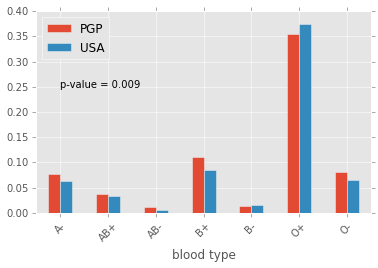

In [31]:
bloodData2 = bloodData/bTotal
ax = bloodData2[1:].plot(kind = 'bar')
labels = ax.get_xticklabels()
ax.set_xticklabels(bloodData[1:].index,rotation=45);
ax.set_xlabel('blood type');
plt.gcf().subplots_adjust(bottom=0.2)
plt.text(0,.25,'p-value = 0.009')
plt.savefig('bloodtypeAll.svg',format='svg')

In [32]:
#idx = alldata['phenotype_x'].str.contains('White',na=False)
#idx2 = alldata['phenotype_x'].str.contains(',',na=False)
#alldataW = alldata[idx&~idx2]

idx = alldata['race'].str.contains('White',na=False)
alldataW = alldata[idx]
bloodtypeW = alldataW.groupby('blood_type')['human_id'].count()

In [33]:
bloodDataW = pd.DataFrame(columns=['PGP - White'])
bloodDataW['PGP - White'] = bloodtypeW[1:]
wTotal =  bloodtypeW[1:].sum()
bloodDataW['USA - White'] = [0.33, .07, .03, .01,.09,.02,.37,.08];
bloodDataW['USA - White'] = wTotal*bloodDataW['USA - White']

chi2, pvalue = stats.chisquare(bloodDataW['PGP - White'].values, f_exp= bloodDataW['USA - White'].values, axis=None)

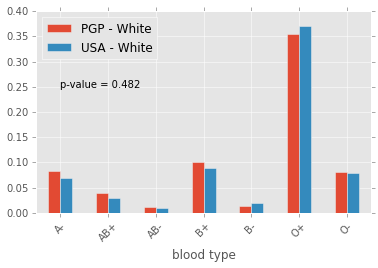

In [34]:
bloodDataW2 = bloodDataW /wTotal
ax = bloodDataW2[1:].plot(kind = 'bar')
labels = ax.get_xticklabels()
ax.set_xticklabels(bloodDataW[1:].index,rotation=45);
ax.set_xlabel('blood type');
plt.text(0,0.25,'p-value = 0.482')
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig('bloodtypeWhite.svg',format='svg')

In [35]:
state = alldata.groupby('state')['human_id'].count()

In [36]:
# read in population information
statePop = pd.read_csv('StatePop.txt',delimiter='\t',names=['Rank','State', 'Pop'],index_col=1)
statePop.Pop = statePop.Pop.str.replace(',','')
statePop.Pop = statePop.Pop.astype(float)*1e-6

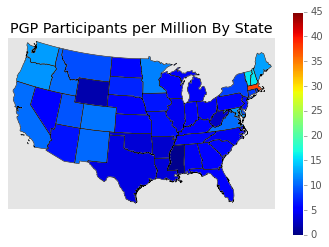

In [37]:
# basemap of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

# read in state shapefile
shp_info = m.readshapefile('states','states',drawbounds=True)

# pick colormap
cmap = plt.cm.jet

colors={}
statenames=[]
vmin = 0; vmax = 45; # set range.

for shapedict in m.states_info:
    # cycle through state names, set color for each one.
    statename = shapedict['STATE_NAME']
    # skip DC and Puerto Rico.
    if statename not in ['District of Columbia','Puerto Rico']:
        pop = state[statename]/statePop.Pop[statename]
        colors[statename] = cmap(0 + (float(pop)/vmax))
    statenames.append(statename)


ax = plt.gca() # get current axes instance

for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if statenames[nshape] not in ['District of Columbia','Puerto Rico']:
        color = colors[statenames[nshape]]
        poly = Polygon(seg,facecolor= color)
        ax.add_patch(poly)

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array(np.linspace(vmin,vmax,10))
cb = plt.colorbar(sm)
cb.ax.yaxis.set_ticks_position('right')

# add title
plt.title('PGP Participants per Million By State')
plt.savefig('PGPMap.jpg', format='jpeg')